In [1]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
import sys
sys.path.append('/Users/rociokiman/Documents/Gaia-Cupid/ActivityAgeRelation/banyan_sigma')
from banyan_sigma import banyan_sigma
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u
%config InlineBackend.figure_format = 'retina'

In [2]:
mg_literature = Table.read('Catalogs/mactivity_movinggroups_gaia.fits')

In [3]:
mg_ref = Table.read('Catalogs/moving_groups_ref.csv',format='csv')
source_ref_table = Table.read('Catalogs/source_ref.csv',format='csv')

# Distinguish accreation from chromospheric emission

In [4]:
def spt_to_g_rp(spt):
    """
    Relation from Kiman et al. 2019
    """
    return -0.0036*spt**2 + 0.11*spt + 0.89

def def_mask_acc(color,ewha):
    if(color<spt_to_g_rp(2.7)):
        return ewha < 10
    elif(color<spt_to_g_rp(5.7)):
        return ewha < 20
    elif(color>=spt_to_g_rp(5.7)):
        return ewha < 40
    else:
        return False

In [5]:
mask_acc = []
for x,y in zip(mg_literature['phot_g_mean_mag']-mg_literature['phot_rp_mean_mag'],mg_literature['ewha']):
    mask_acc.append(def_mask_acc(x,y))
mask_acc = np.array(mask_acc)

mask_abs = mg_literature['ewha'] > 0

mask_snr_ha = mg_literature['ewha']/mg_literature['ewha_error'] > 3

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


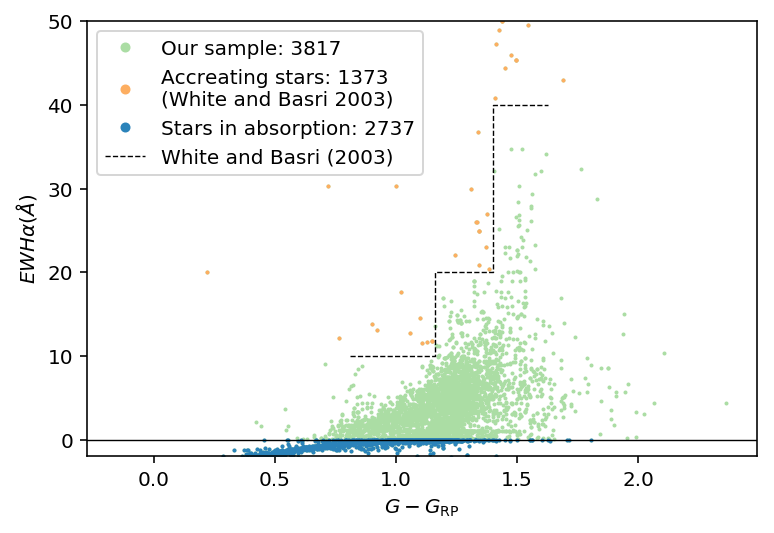

In [6]:
N = 10
linewidth = 0.7
x1 = np.linspace(spt_to_g_rp(-.7),spt_to_g_rp(2.7),N)
y1 = np.ones(N)*10
x2 = np.linspace(spt_to_g_rp(2.7),spt_to_g_rp(5.7),N)
y2 = np.ones(N)*20
x3 = np.linspace(spt_to_g_rp(5.7),spt_to_g_rp(10),N)
y3 = np.ones(N)*40
plt.plot(mg_literature['phot_g_mean_mag']-mg_literature['phot_rp_mean_mag'],mg_literature['ewha'],
         '.',markersize=2,color='#abdda4',label='Our sample: {}'.format(len(mg_literature['phot_rp_mean_mag'][mask_acc*mask_abs])))
plt.plot(mg_literature['phot_g_mean_mag'][~mask_acc]-mg_literature['phot_rp_mean_mag'][~mask_acc],mg_literature['ewha'][~mask_acc],
         '.',markersize=2,label='Accreating stars: {}\n(White and Basri 2003)'.format(len(mg_literature['phot_rp_mean_mag'][~mask_acc]))
         ,color='#fdae61')
plt.plot(mg_literature['phot_g_mean_mag'][~mask_abs]-mg_literature['phot_rp_mean_mag'][~mask_abs],mg_literature['ewha'][~mask_abs],
         '.',markersize=2,label='Stars in absorption: {}'.format(len(mg_literature['phot_g_mean_mag'][~mask_abs])),
         color='#2b83ba')
plt.plot(np.concatenate((x1,x2,x3)),np.concatenate((y1,y2,y3)),'--k',linewidth=linewidth,
         label='White and Basri (2003)')
plt.axhline(y=0,color='k',linewidth=linewidth)
plt.ylim(-2,50)
plt.legend(markerscale=4)
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'$EWH\alpha (\AA)$')
plt.savefig('Figures/limits_halpha.png',dpi=300)

# Members from the literature: Checking compatibility

In [7]:
mg_mlsdss = fits.open('Catalogs/mactivity_movinggroups_gaia_mlsdss.fits')

In [8]:
len(mg_mlsdss[1].data['EWHA_2'])

6656

In [9]:
mask_match_compatible = ~np.isnan(mg_mlsdss[1].data['EWHA_2'])

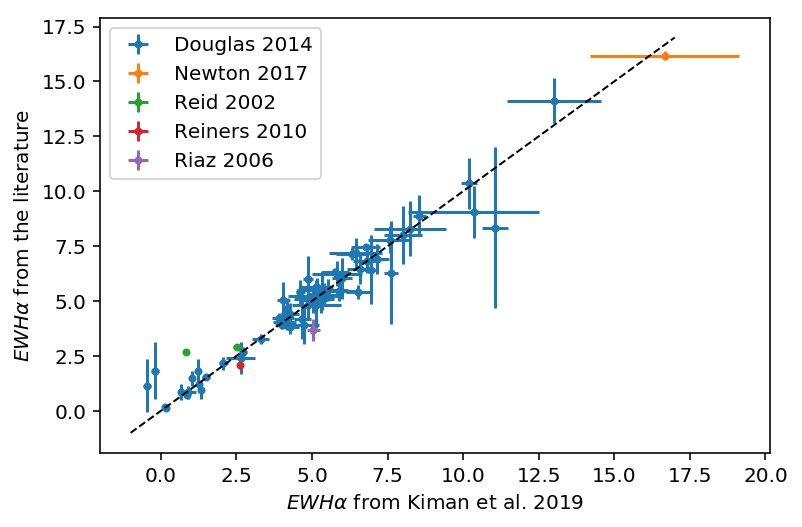

In [45]:
compatible_groups = []
for i in range(len(source_ref_table['source_num'])):
    x = source_ref_table['source_num'][i]
    if(x!=source_ref_table['source_num'][source_ref_table['source_ref']=='Kiman 2019'][0]):
        if(x in mg_mlsdss[1].data['source_num'][mask_match_compatible]):
            compatible_groups.append(x)
            mask = mg_mlsdss[1].data['source_num'] == x
            plt.errorbar(mg_mlsdss[1].data['EWHA_2'][mask],mg_mlsdss[1].data['ewha_1'][mask],
                         yerr = mg_mlsdss[1].data['ewha_error'][mask], 
                         xerr = mg_mlsdss[1].data['EWHA_ERR'][mask],
                         label=source_ref_table['source_ref'][i],fmt='.',zorder=0)
x = np.linspace(-1,17,10)
plt.plot(x,x,'--k',linewidth=1,zorder=2)
plt.xlabel(r'$EWH\alpha$ from Kiman et al. 2019')
plt.ylabel(r'$EWH\alpha$ from the literature')
plt.legend()
plt.savefig('Figures/CompatibleStars.png',dpi=300)
plt.show()

compatible_groups = np.array(compatible_groups)

In [46]:
mask_compatible = np.array([x in compatible_groups for x in mg_literature['source_num']])

In [47]:
compatible_groups

array([ 4, 28, 31, 35, 36])

## Running Banyan on literature sample of stars

In [48]:
ra = np.array([float(x) for x in mg_literature['ra_x']])
ra_err = np.array([float(x) for x in mg_literature['ra_error']])
dec = np.array([float(x) for x in mg_literature['dec_x']])
pmra = np.array([float(x) for x in mg_literature['pmra']])
pmra_error = np.array([float(x) for x in mg_literature['pmra_error']])
pmdec = np.array([float(x) for x in mg_literature['pmdec']])
pmdec_error = np.array([float(x) for x in mg_literature['pmdec_error']])
parallax = np.array([float(x) for x in mg_literature['parallax']])
parallax_error = np.array([float(x) for x in mg_literature['parallax_error']])
rv = np.array([float(x) for x in mg_literature['radial_velocity']])
rv_error = np.array([float(x) for x in mg_literature['radial_velocity_error']])

In [49]:
len(ra)

6656

In [50]:
mask_compiled_literature = (~np.isnan(ra+dec+pmra+pmra_error+pmdec+pmdec_error+parallax+parallax_error) 
                            * (parallax/parallax_error > 8)
                            * mask_compatible
                            * mask_abs
                            * mask_acc
                            * mask_snr_ha)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [51]:
len(ra[mask_compiled_literature])

1282

In [52]:
OUTPUT_STRUCTURE1 = banyan_sigma(ra=ra[mask_compiled_literature], dec=dec[mask_compiled_literature], 
                                 pmra=pmra[mask_compiled_literature], pmdec=pmdec[mask_compiled_literature], 
                                 epmra=pmra_error[mask_compiled_literature], 
                                 epmdec=pmdec_error[mask_compiled_literature],
                                 rv=rv[mask_compiled_literature], erv=rv_error[mask_compiled_literature], 
                                 plx=parallax[mask_compiled_literature], 
                                 eplx=parallax_error[mask_compiled_literature])

In [53]:
prob_ya_literature = np.array(OUTPUT_STRUCTURE1['YA_PROB']).reshape(len(OUTPUT_STRUCTURE1['YA_PROB']),)
best_ya_literature = np.array(OUTPUT_STRUCTURE1['BEST_YA']).reshape(len(OUTPUT_STRUCTURE1['BEST_YA']),)

In [54]:
highprob_literature = prob_ya_literature > 0.8


In [55]:
len(best_ya_literature[highprob_literature])

268

In [56]:
mask_highprob_literature = highprob_literature.reshape(len(highprob_literature),)

# Praesepe Members

In [57]:
source_id_praesepe = np.loadtxt('Catalogs/source_id_pra.txt')

In [58]:
bf_pra = np.array([True if x in source_id_praesepe else False for x in mg_literature['source_id']])

In [59]:
def remove(string): 
    return string.replace(" ", "")

In [60]:
for i in range(len(mg_literature['group_name'])):
    if(remove(mg_literature['group_name'][i])=='PRA' and bf_pra[i]):
        mg_literature['group_name'][i] = 'PRA'
        mg_literature['group_num'][i] = mg_ref['group_num'][mg_ref['name']=='PRA'][0]
        mg_literature['age'][i] = mg_ref['age'][mg_ref['name']=='PRA'][0]
        mg_literature['age_error'][i] = mg_ref['age_error'][mg_ref['name']=='PRA'][0]

# Literature checked with Banyan + Praesepe

In [61]:
mask_membership = np.logical_or(mask_highprob_literature,bf_pra[mask_compiled_literature])

In [62]:
mg_literature_clean = mg_literature[mask_compiled_literature][mask_membership]

In [63]:
mg_literature_clean['ya_prob'] = prob_ya_literature[mask_membership]
mg_literature_clean['best_ya'] = np.array([str(x) for x in best_ya_literature[mask_membership]])

In [64]:
len(mg_literature_clean)

291

# Correcting groups that don't agree

In [65]:
for i in range(len(mg_literature_clean)):
    if(mg_literature_clean['group_name'][i]!=mg_literature_clean['best_ya'][i]):
        if(mg_literature_clean['group_name'][i]!='PRA'):
            mask = mg_literature_clean['best_ya'][i] == mg_ref['name']
            mg_literature_clean['group_name'][i] = mg_ref['name'][mask][0]
            mg_literature_clean['group_num'][i] = mg_ref['group_num'][mask][0]
            mg_literature_clean['age'][i] = mg_ref['age'][mask][0]
            mg_literature_clean['age_error'][i] = mg_ref['age_error'][mask][0]
        elif(mg_literature_clean['group_name'][i]=='PRA'):
            mg_literature_clean['best_ya'][i] = 'PRA'
            mg_literature_clean['ya_prob'][i] = np.nan

# Members from MLSDSS-GaiaDR2

In [66]:
mlsdss = Table.read('../Gaia-Cupid/Catalogs/MLSDSS-GaiaDR2.fits')

In [67]:
mask_acc_mlsdss = []
for x,y in zip(mlsdss['phot_g_mean_mag']-mlsdss['phot_rp_mean_mag'],mlsdss['EWHA']):
    mask_acc_mlsdss.append(def_mask_acc(x,y))
mask_acc_mlsdss = np.array(mask_acc_mlsdss)

mask_abs_mlsdss = mlsdss['EWHA'] > 0

mask_snr_ha_mlsdss = mlsdss['EWHA']/mlsdss['EWHA_ERR'] > 3

In [68]:
mask_compiled_mlsdss = (~np.isnan(mlsdss['RA']+mlsdss['DEC']+mlsdss['PMRA']+mlsdss['PMDEC']
                                  +mlsdss['PMRA_ERR']+mlsdss['PMDEC_ERR']+mlsdss['RV']
                                  +mlsdss['RV_ERR']+mlsdss['parallax']+mlsdss['parallax_error'])
                        * (mlsdss['GOODMATCH'] == 1) 
                        * (mlsdss['parallax']/mlsdss['parallax_error'] > 8)
                        * mask_acc_mlsdss
                        * mask_abs_mlsdss
                        * mask_snr_ha_mlsdss)

In [69]:
OUTPUT_STRUCTURE2 = banyan_sigma(ra=mlsdss['RA'][mask_compiled_mlsdss], dec=mlsdss['DEC'][mask_compiled_mlsdss], 
                                 pmra=mlsdss['PMRA'][mask_compiled_mlsdss], 
                                 pmdec=mlsdss['PMDEC'][mask_compiled_mlsdss], 
                                 epmra=mlsdss['PMRA_ERR'][mask_compiled_mlsdss], 
                                 epmdec=mlsdss['PMDEC_ERR'][mask_compiled_mlsdss],
                                 rv=mlsdss['RV'][mask_compiled_mlsdss], erv=mlsdss['RV_ERR'][mask_compiled_mlsdss], 
                                 plx=mlsdss['parallax'][mask_compiled_mlsdss], 
                                 eplx=mlsdss['parallax_error'][mask_compiled_mlsdss])

In [70]:
prob_ya_mlsdss = np.array(OUTPUT_STRUCTURE2['YA_PROB']).reshape(len(OUTPUT_STRUCTURE2['YA_PROB']),)
best_ya_mlsdss = np.array(OUTPUT_STRUCTURE2['BEST_YA']).reshape(len(OUTPUT_STRUCTURE2['BEST_YA']),)

In [71]:
mask_highprob_mlsdss = prob_ya_mlsdss > 0.8

In [72]:
len(best_ya_mlsdss[mask_highprob_mlsdss])

19

In [73]:
mlsdss_mg_clean = mlsdss[mask_compiled_mlsdss][mask_highprob_mlsdss]

In [74]:
mlsdss_mg_clean['best_ya'] = best_ya_mlsdss[mask_highprob_mlsdss]
mlsdss_mg_clean['ya_prob'] = prob_ya_mlsdss[mask_highprob_mlsdss]

In [75]:
age = []
age_error = []
group_name = []
group_num = []
for i in range(len(mlsdss_mg_clean['best_ya'])):
    mask = mlsdss_mg_clean['best_ya'][i] == mg_ref['name']
    age.append(mg_ref['age'][mask][0])
    age_error.append(mg_ref['age_error'][mask][0])
    group_name.append(mg_ref['name'][mask][0])
    group_num.append(mg_ref['group_num'][mask][0])

source_num = np.ones(len(mlsdss_mg_clean['ya_prob']))*source_ref_table['source_num'][source_ref_table['source_ref']=='Kiman 2019'][0]
source_ref = np.array(['Kiman 2019' for x in range(len(mlsdss_mg_clean['ya_prob']))])
    
age,age_error,group_name,group_num = np.array(age),np.array(age_error),np.array(group_name),np.array(group_num)

# Compiling full sample of M dwarfs from moving groups

In [76]:
fullsample = Table()

In [77]:
fullsample['ra'] = np.concatenate((mg_literature_clean['ra'],mlsdss_mg_clean['RA']))
fullsample['dec'] = np.concatenate((mg_literature_clean['dec'],mlsdss_mg_clean['DEC']))
fullsample['ra_gaia'] = np.concatenate((mg_literature_clean['ra_x'],mlsdss_mg_clean['RA']))
fullsample['dec_gaia'] = np.concatenate((mg_literature_clean['dec_x'],mlsdss_mg_clean['DEC']))
fullsample['spt'] = np.concatenate((mg_literature_clean['spt'],mlsdss_mg_clean['SPT']))
fullsample['phot_g_mean_mag'] = np.concatenate((mg_literature_clean['phot_g_mean_mag'],mlsdss_mg_clean['phot_g_mean_mag']))
fullsample['phot_rp_mean_mag'] = np.concatenate((mg_literature_clean['phot_rp_mean_mag'],mlsdss_mg_clean['phot_rp_mean_mag']))
fullsample['phot_bp_mean_mag'] = np.concatenate((mg_literature_clean['phot_bp_mean_mag'],mlsdss_mg_clean['phot_bp_mean_mag']))
fullsample['parallax'] = np.concatenate((mg_literature_clean['parallax'],mlsdss_mg_clean['parallax']))
fullsample['parallax_error'] = np.concatenate((mg_literature_clean['parallax_error'],mlsdss_mg_clean['parallax_error']))
fullsample['ewha'] = np.concatenate((mg_literature_clean['ewha'],mlsdss_mg_clean['EWHA']))
fullsample['ewha_error'] = np.concatenate((mg_literature_clean['ewha_error'],mlsdss_mg_clean['EWHA_ERR']))
fullsample['lhalbol'] = np.concatenate((mg_literature_clean['lhalbol'],mlsdss_mg_clean['LHALBOL']))
fullsample['lhalbol_error'] = np.concatenate((mg_literature_clean['lhalbol_error'],mlsdss_mg_clean['LHALBOL_ERR']))
fullsample['age'] = np.concatenate((mg_literature_clean['age'],age))
fullsample['age_error'] = np.concatenate((mg_literature_clean['age_error'],age_error))
fullsample['group_num'] = np.concatenate((mg_literature_clean['group_num'],group_num))
fullsample['group_name'] = np.concatenate((mg_literature_clean['group_name'],group_name))
fullsample['ya_prob'] = np.concatenate((mg_literature_clean['ya_prob'],mlsdss_mg_clean['ya_prob']))
fullsample['source_num'] = np.concatenate((mg_literature_clean['source_num'],source_num))
fullsample['source_ref'] = np.concatenate((mg_literature_clean['source_ref'],source_ref))

In [78]:
len(fullsample)

310

# Identify repeated stars

In [79]:
extra_id = np.arange(len(fullsample['ra']))
idx_sorted = np.argsort(fullsample['ra'])
ra_sorted = fullsample['ra'][idx_sorted]
dec_sorted = fullsample['dec'][idx_sorted]
extra_id_sorted = extra_id[idx_sorted]

In [80]:
same_star = np.zeros(len(ra_sorted))
dummy = 1
for i in range(len(ra_sorted)-1):
    c1 = SkyCoord(ra=ra_sorted[i]*u.deg, dec=dec_sorted[i]*u.deg)
    c2 = SkyCoord(ra=ra_sorted[i+1]*u.deg, dec=dec_sorted[i+1]*u.deg)
    separation = c1.separation(c2).arcsec
    if(separation < 2):
        same_star[i] = dummy
        same_star[i+1] = dummy
    else:
        dummy +=1

In [81]:
remove_idx = np.zeros(len(fullsample))
for x in np.arange(1,int(max(same_star))+1):
    mask = same_star == x
    if(any(mask)):
        same_star_id = extra_id_sorted[mask]
        if(all(np.isclose(x,fullsample[same_star_id]['ra_gaia'][0]) for x in fullsample[same_star_id]['ra_gaia']) and
           all(np.isclose(x,fullsample[same_star_id]['dec_gaia'][0]) for x in fullsample[same_star_id]['dec_gaia'])):
            for i in same_star_id[1:]:
                remove_idx[i] = 1
        else:
            print(fullsample[same_star_id]['ra_gaia','dec_gaia'])


In [82]:
mask_remove_same_stars = remove_idx == 0

In [83]:
fullsample_singles = fullsample[mask_remove_same_stars]

In [84]:
idx_sorted_test = np.argsort(fullsample_singles['ra'])
ra_sorted_test = fullsample_singles['ra'][idx_sorted_test]
dec_sorted_test = fullsample_singles['dec'][idx_sorted_test]

In [85]:
for i in range(len(ra_sorted_test)-1):
    c1 = SkyCoord(ra=ra_sorted_test[i]*u.deg, dec=dec_sorted_test[i]*u.deg)
    c2 = SkyCoord(ra=ra_sorted_test[i+1]*u.deg, dec=dec_sorted_test[i+1]*u.deg)
    separation = c1.separation(c2).arcsec
    if(separation < 2):
        print(c1,c2)

In [86]:
len(fullsample_singles)

308

# Save final sample

In [87]:
fullsample_singles.write('Catalogs/mactivity_movinggroups_confirmed.fits',format='fits',overwrite=True)